In [2]:
#----Initialization----------------------
import numpy as np
import pandas as pd
import tensorflow
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.special import softmax
from scipy import sparse
from scipy.optimize import leastsq
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math
pi=math.pi
exp=math.exp

In [3]:
# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

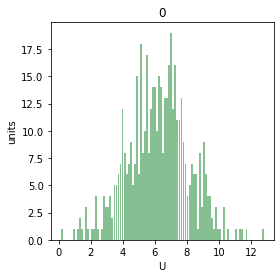

In [4]:
inp_up=np.loadtxt('Gfupin.dat') # input with 2,4,6 orbital 100 random U
inp_dw=np.loadtxt('Gfdwin.dat')
out_up=np.loadtxt('Gfupout.dat') # output with 8 orbital 100
out_dw=np.loadtxt('Gfdwout.dat')
#------------------To cross check we reshape-------------
Ginp_up=np.reshape(inp_up, (500,256*3), order='C')
Ginp_dw=np.reshape(inp_dw, (500,256*3),order='C')
Gout_up=np.reshape(out_up, (500,256),order='C')
Gout_dw=np.reshape(out_dw, (500,256),order='C')

tmp=np.reshape(Ginp_up,(500,256,3))
tmpdw=np.reshape(Ginp_dw,(500,256,3))


interaction=np.loadtxt('../U.dat')
dfint=pd.DataFrame(data=interaction)
dfint.hist(bins=100, grid=False, figsize=(4,4), color='#86bf91', zorder=2, rwidth=0.9)
plt.xlabel('U')
plt.ylabel("units")
plt.show()

In [5]:
wn=np.arange(0,256)
x=wn
y=tmp[2,:,0]+0.0001

In [ ]:
def step(x):
    return 0.5*(np.sign(x) + np.sign(1 - x))

In [15]:
def func2(params, x, y):
    a,b,c,d,e=params[0], params[1], params[2],params[3], params[4]
    residual=y-(a*np.exp(b*x**2-c*x-d)+e)
    return residual

In [16]:
params = [0, 0, 0, 0, 0]

In [17]:
result = leastsq(func2, params, (x, y),maxfev=10000)
a, b, c,d, e=result[0][0], result[0][1], result[0][2],result[0][3], result[0][4]
print(a,b,c,d,e)
yfit1=a*np.exp(b*x**2-c*x-d)+e

4.075360117167561e-36 0.0024771334115842127 0.6216707974081049 -78.84950394138903 0.00038736833818944896


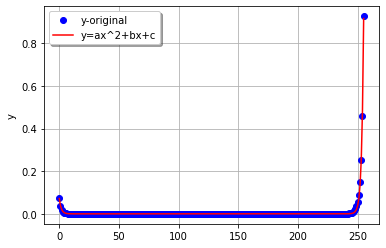

In [18]:
plt.plot(x, y, 'bo', label="y-original")
plt.plot(x, yfit1, color="red", label="y=ax^2+bx+c")
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


In [ ]:
popt_f=[]
for i in range(500):
    ydata=tmp[i,:,0]
    guess=[1.0,1.0,1.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2]])

d2orb=pd.DataFrame(popt_f)   
d2orb.columns=['param02','param12','param22']
#y_new=func(wn, popt[0], popt[1], popt[2], popt[3], popt[4])

index=d2orb.iloc[6].to_numpy()
print(index)
y_new=func(wn, index[0], index[1],index[2])

plt.plot(wn, y_new)
plt.plot(wn, tmp[6,:,0],'o')

In [ ]:
popt_f=[]
for i in range(500):
    ydata=tmp[i,:,1]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d4orb=pd.DataFrame(popt_f)
d4orb.columns=['param04','param14','param24','param34','param44']
d4orb

In [ ]:
popt_f=[]
for i in range(500):
    ydata=tmp[i,:,2]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d6orb=pd.DataFrame(popt_f)
d6orb.columns=['param06','param16','param26','param36','param46']
d6orb

In [ ]:
popt_f=[]
for i in range(500):
    ydata=Gout_up[i,:]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d8orb=pd.DataFrame(popt_f)
d8orb.columns=['param08','param18','param28','param38','param48']
d8orb.hist(column='param08',bins=20)

In [ ]:
Gin = pd.concat([d2orb, d4orb,d6orb], axis=1)
Gin
X=Gin.to_numpy()
y=d8orb.to_numpy()
print(y.shape[1])

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(10, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    #model.add(Dense(5, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer=RMSprop(),metrics = ['accuracy'])
    return model
 

In [ ]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # define model
    model = get_model(n_inputs, n_outputs)
    # fit model
    history=model.fit(X_train, y_train, verbose=0, epochs=500,validation_data=(X_test,y_test))
    # evaluate model on test set
    mae = model.evaluate(X_test, y_test, verbose=0)
    # store result
    print('>%.3f %.3f' % (mae[0],mae[1]))
    results.append(mae)
    return results, history


In [ ]:
# evaluate model
results, history = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='valLoss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print("%s: %.4f%%" % (model.metrics_names[1], score[1]*100))

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
X_train.shape

In [ ]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
model = get_model(n_inputs, n_outputs)
index = model.predict(X_test)
print('Predicted: %s' % index[0])

In [ ]:
y_new=func(wn, index[0,0], index[0,1], index[0,2], index[0,3],index[0,4])
plt.plot(wn, y_new)